# Assignment 4 – Variational Autoencoder (VAE)

### 🎯 Objective
To explore how changing the latent space dimensionality from 2 to 3 affects a VAE’s performance and visualization capabilities using the MNIST dataset.

### 🛠️ Method
- Used the MNIST dataset (28x28 images flattened to 784).
- Modified the VAE model to use a 3D latent space instead of 2D.
- Printed the shape of the encoder’s latent output `z_mean`.
- Visualized pairwise latent projections using `seaborn.pairplot`.

#### Original Code

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets
from tensorflow.keras import  optimizers, metrics

def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

def load_and_preprocess_data ():
    (x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
    x_train = preprocess(x_train)
    x_test = preprocess(x_test)
    return (x_train, y_train), (x_test, y_test)

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0] # number of samples in the batch
        dim = tf.shape(z_mean)[1]   # dimension of latent space
        epsilon = tf.random.normal(shape=(batch, dim))
        #tf.print("Epsilon:", epsilon)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(models.Model):
    def __init__(self, encoder_inputs, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        # Define encoder layers
        x = layers.Conv2D(32, 3, strides=2, activation="relu", padding="same")(encoder_inputs)
        x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
        x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)

        # Store shape before flattening for the decoder
        self.shape_before_flattening = K.int_shape(x)[1:]

        x = layers.Flatten()(x)
        self.z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([self.z_mean, self.z_log_var])
        self.encoder = models.Model(encoder_inputs, [self.z_mean, self.z_log_var, z], name="encoder")

        # Define decoder layers
        latent_inputs = layers.Input(shape=(latent_dim,))
        x = layers.Dense(np.prod(self.shape_before_flattening))(latent_inputs)
        x = layers.Reshape(self.shape_before_flattening)(x)
        x = layers.Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same")(x)
        x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
        decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

        self.decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")

        # Metrics for tracking
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            # Get encoder outputs
            z_mean, z_log_var, z = self.encoder(data)

            # Get reconstruction
            reconstruction = self.decoder(z)

            # Calculate reconstruction loss with fixed dimensions
            reconstruction_loss = tf.reduce_mean(
                500 * tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction),
                    axis=[1, 2] #  input (batch, height, width, 1)
                )
            )

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
                )
            )

            total_loss = reconstruction_loss + kl_loss

        # Get gradients and apply them
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        # Get encoder outputs
        z_mean, z_log_var, z = self.encoder(data)

        # Get reconstruction
        reconstruction = self.decoder(z)

        # Calculate reconstruction loss with fixed dimensions
        reconstruction_loss = tf.reduce_mean(
            500 * tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstruction),
                axis=[1, 2] # We know our input is (batch, height, width, 1)
            )
        )

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            )
        )

        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

def plot_training_hist(history):
    # Plot training history
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
    plt.plot(history.history['kl_loss'], label='KL Loss')
    plt.title('Loss Components')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

def visulize_reconstruction(vae, x_test):
    n = 5
    example_images = x_test[:n]
    z_mean, z_log_var, z = vae.encoder.predict(example_images)
    reconstructions = vae.decoder.predict(z)

    # Plot original and reconstructed images
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(example_images[i].reshape(32, 32), cmap='gray')
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructions[i].reshape(32, 32), cmap='gray')
        plt.title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

def visulize_latent(vae, x_test,n=10):
    # Visualize the latent space
    test_samples = x_test[:n]
    test_labels = y_test[:n]
    z_mean, z_log_var, z = vae.encoder.predict(test_samples)

    # Create scatter plot
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=test_labels,
                         cmap='tab10', alpha=0.7, s=20)
    plt.colorbar(scatter)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization of Fashion MNIST')
    plt.grid(alpha=0.3)
    plt.show()

def generate_image(vae, n=5, z_range=1):
    """
    Generate and display n images from the latent space of a trained VAE model.

    Parameters:
    - vae: Trained VAE model (with .decoder)
    - n: Number of images to generate
    - z_range: Sampling range for latent variables (e.g., [-2, 2])
    """
    z_samples = np.random.uniform(low=-z_range, high=z_range, size=(n, 2))
    decoded_images = vae.decoder.predict(z_samples)
    plt.figure(figsize=(n * 2, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(decoded_images[i].squeeze(), cmap="gray")
        plt.title(f"z={z_samples[i]}")
        plt.axis("off")

    plt.suptitle("Samples from VAE Latent Space", fontsize=16)
    plt.tight_layout()
    plt.show()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
600/600 ━━━━━━━━━━━━━━━━━━━━ 238s 382ms/step - kl_loss: 67.1923 - loss: 182168.7031 - reconstruction_loss: 182101.5000 - val_kl_loss: 31.6824 - val_loss: 137922.2500 - val_reconstruction_loss: 137890.5625
Epoch 2/2
600/600 ━━━━━━━━━━━━━━━━━━━━ 236s 393ms/step - kl_loss: 31.1046 - loss: 133076.0000 - reconstruction_loss: 133044.9219 - val_kl_loss: 27.6533 - val_loss: 134004.6875 - val_reconstruction_loss: 133977.0312


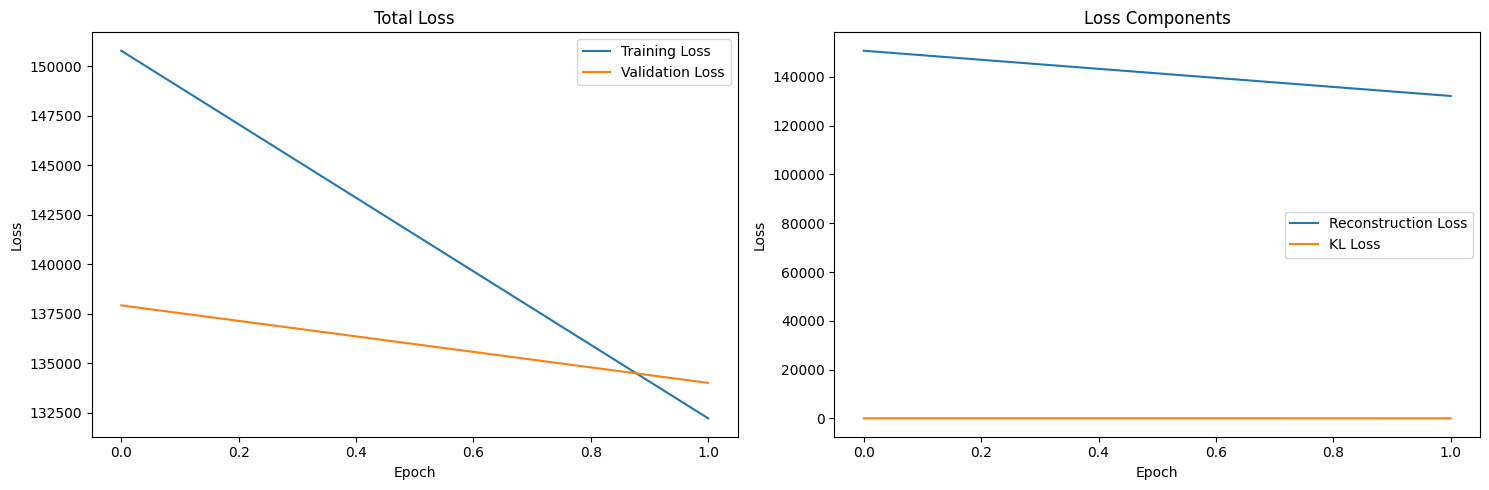

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


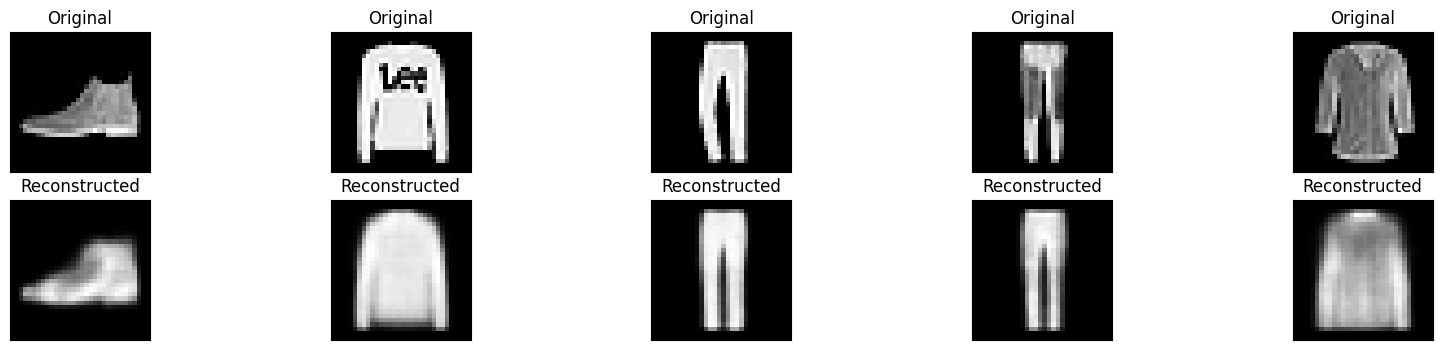

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


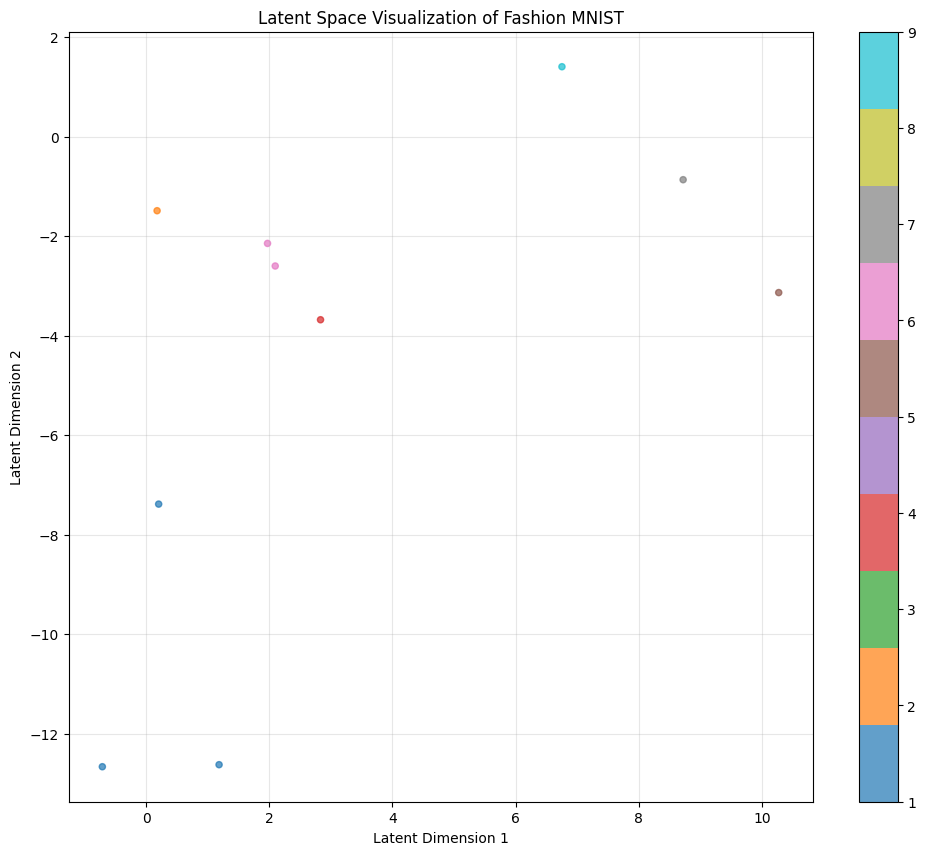

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


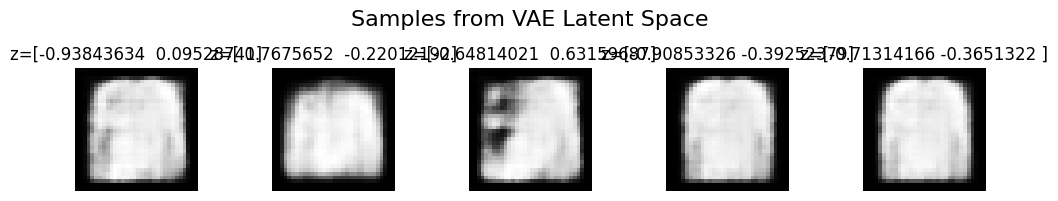

Fashion MNIST class labels:
0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


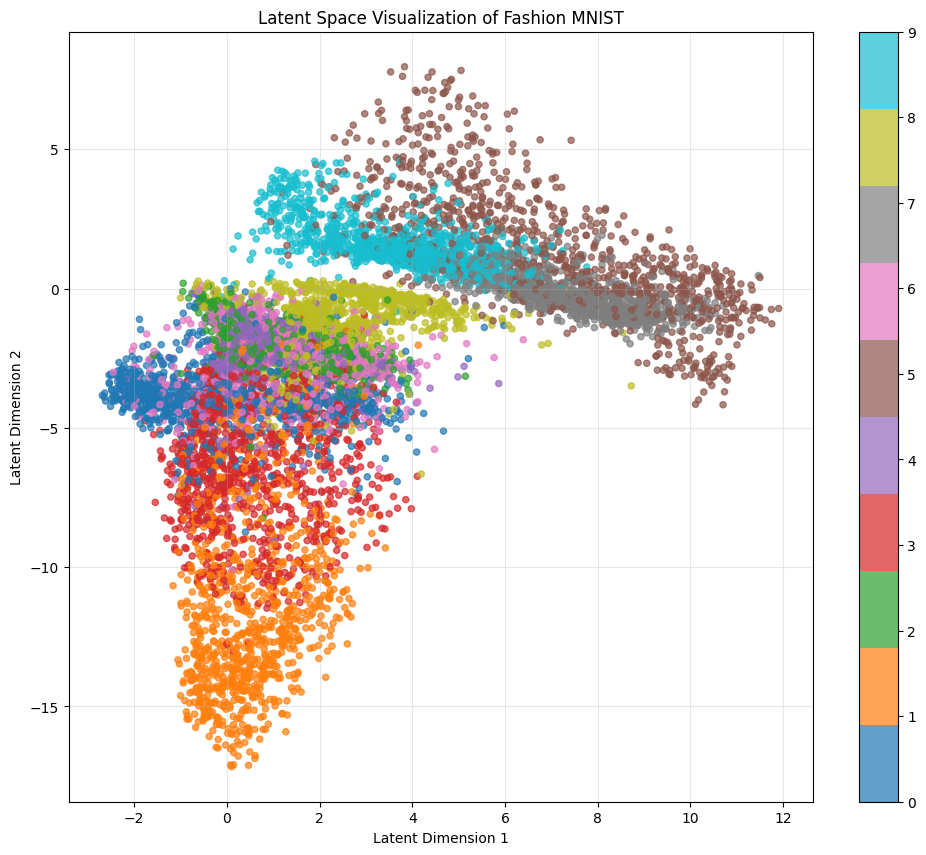

In [ ]:
(x_train, y_train), (x_test, y_test) = load_and_preprocess_data()
encoder_inputs = layers.Input(shape=(32, 32, 1))
vae = VAE(encoder_inputs, 2)
vae.compile(optimizer=optimizers.Adam(learning_rate=0.001))
vae.encoder.summary()

history = vae.fit( x_train, epochs=2, batch_size=100, shuffle=True, validation_data=(x_test, None))
plot_training_hist(history)
visulize_reconstruction(vae, x_test)
visulize_latent(vae, x_test)
generate_image(vae, z_range=1)

# Print class names for reference
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
print("Fashion MNIST class labels:")
for i, label in enumerate(fashion_mnist_labels):
    print(f"{i}: {label}")

visulize_latent(vae, x_test,10000)

#### Modifieded Version

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets
from tensorflow.keras import  optimizers, metrics

def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

def load_and_preprocess_data ():
    (x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
    x_train = preprocess(x_train)
    x_test = preprocess(x_test)
    return (x_train, y_train), (x_test, y_test)

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0] # number of samples in the batch
        dim = tf.shape(z_mean)[1]   # dimension of latent space
        epsilon = tf.random.normal(shape=(batch, dim))
        #tf.print("Epsilon:", epsilon)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(models.Model):
    def __init__(self, encoder_inputs, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        # Define encoder layers
        x = layers.Conv2D(32, 3, strides=2, activation="relu", padding="same")(encoder_inputs)
        x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
        x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)

        # Store shape before flattening for the decoder
        self.shape_before_flattening = K.int_shape(x)[1:]

        x = layers.Flatten()(x)
        self.z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([self.z_mean, self.z_log_var])
        self.encoder = models.Model(encoder_inputs, [self.z_mean, self.z_log_var, z], name="encoder")

        # Define decoder layers
        latent_inputs = layers.Input(shape=(latent_dim,))
        x = layers.Dense(np.prod(self.shape_before_flattening))(latent_inputs)
        x = layers.Reshape(self.shape_before_flattening)(x)
        x = layers.Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same")(x)
        x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
        decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

        self.decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")

        # Metrics for tracking
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            # Get encoder outputs
            z_mean, z_log_var, z = self.encoder(data)

            # Get reconstruction
            reconstruction = self.decoder(z)

            # Calculate reconstruction loss with fixed dimensions
            reconstruction_loss = tf.reduce_mean(
                500 * tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction),
                    axis=[1, 2] #  input (batch, height, width, 1)
                )
            )

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
                )
            )

            total_loss = reconstruction_loss + kl_loss

        # Get gradients and apply them
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        # Get encoder outputs
        z_mean, z_log_var, z = self.encoder(data)

        # Get reconstruction
        reconstruction = self.decoder(z)

        # Calculate reconstruction loss with fixed dimensions
        reconstruction_loss = tf.reduce_mean(
            500 * tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstruction),
                axis=[1, 2] # We know our input is (batch, height, width, 1)
            )
        )

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            )
        )

        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

def plot_training_hist(history):
    # Plot training history
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
    plt.plot(history.history['kl_loss'], label='KL Loss')
    plt.title('Loss Components')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

def visulize_reconstruction(vae, x_test):
    n = 5
    example_images = x_test[:n]
    z_mean, z_log_var, z = vae.encoder.predict(example_images)
    reconstructions = vae.decoder.predict(z)

    # Plot original and reconstructed images
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(example_images[i].reshape(32, 32), cmap='gray')
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructions[i].reshape(32, 32), cmap='gray')
        plt.title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


def visulize_latent(vae, x_test,n=10):
    # Visualize the latent space
    test_samples = x_test[:n]
    test_labels = y_test[:n]
    z_mean, z_log_var, z = vae.encoder.predict(test_samples)

    # Print the shape of z_mean
    print(f"Shape of z_mean: {z_mean.shape}")  # Should be (n, 3)

    # Create pairwise plots
    plt.figure(figsize=(15, 10))

    # Plot z1 vs z2
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=test_labels,
                         cmap='tab10', alpha=0.7, s=20)
    plt.colorbar(scatter)
    plt.xlabel('Latent Dimension 1 (z₁)')
    plt.ylabel('Latent Dimension 2 (z₂)')
    plt.title('z₁ vs z₂')
    plt.grid(alpha=0.3)

    # Plot z1 vs z3
    plt.subplot(2, 2, 2)
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 2], c=test_labels,
                         cmap='tab10', alpha=0.7, s=20)
    plt.colorbar(scatter)
    plt.xlabel('Latent Dimension 1 (z₁)')
    plt.ylabel('Latent Dimension 3 (z₃)')
    plt.title('z₁ vs z₃')
    plt.grid(alpha=0.3)

    # Plot z2 vs z3
    plt.subplot(2, 2, 3)
    scatter = plt.scatter(z_mean[:, 1], z_mean[:, 2], c=test_labels,
                         cmap='tab10', alpha=0.7, s=20)
    plt.colorbar(scatter)
    plt.xlabel('Latent Dimension 2 (z₂)')
    plt.ylabel('Latent Dimension 3 (z₃)')
    plt.title('z₂ vs z₃')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def generate_image(vae, n=5, z_range=1):
    """
    Generate and display n images from the latent space of a trained VAE model.

    Parameters:
    - vae: Trained VAE model (with .decoder)
    - n: Number of images to generate
    - z_range: Sampling range for latent variables (e.g., [-2, 2])
    """
    z_samples = np.random.uniform(low=-z_range, high=z_range, size=(n, 3))  # Changed to 3D
    decoded_images = vae.decoder.predict(z_samples)
    plt.figure(figsize=(n * 2, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(decoded_images[i].squeeze(), cmap="gray")
        plt.title(f"z={z_samples[i, :3]}")  # Show first 3 dimensions
        plt.axis("off")

    plt.suptitle("Samples from VAE Latent Space", fontsize=16)
    plt.tight_layout()
    plt.show()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2048)      │          0 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 3)         │      6,147 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 3)         │      6,147 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 3)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 104,966 (410.02 KB)

 Trainable params: 104,966 (410.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
600/600 ━━━━━━━━━━━━━━━━━━━━ 241s 396ms/step - kl_loss: 65.0652 - loss: 179237.8438 - reconstruction_loss: 179172.7812 - val_kl_loss: 41.0023 - val_loss: 129303.0938 - val_reconstruction_loss: 129262.0938
Epoch 2/2
600/600 ━━━━━━━━━━━━━━━━━━━━ 259s 390ms/step - kl_loss: 38.4999 - loss: 125192.2812 - reconstruction_loss: 125153.7656 - val_kl_loss: 31.8590 - val_loss: 126438.6562 - val_reconstruction_loss: 126406.7969


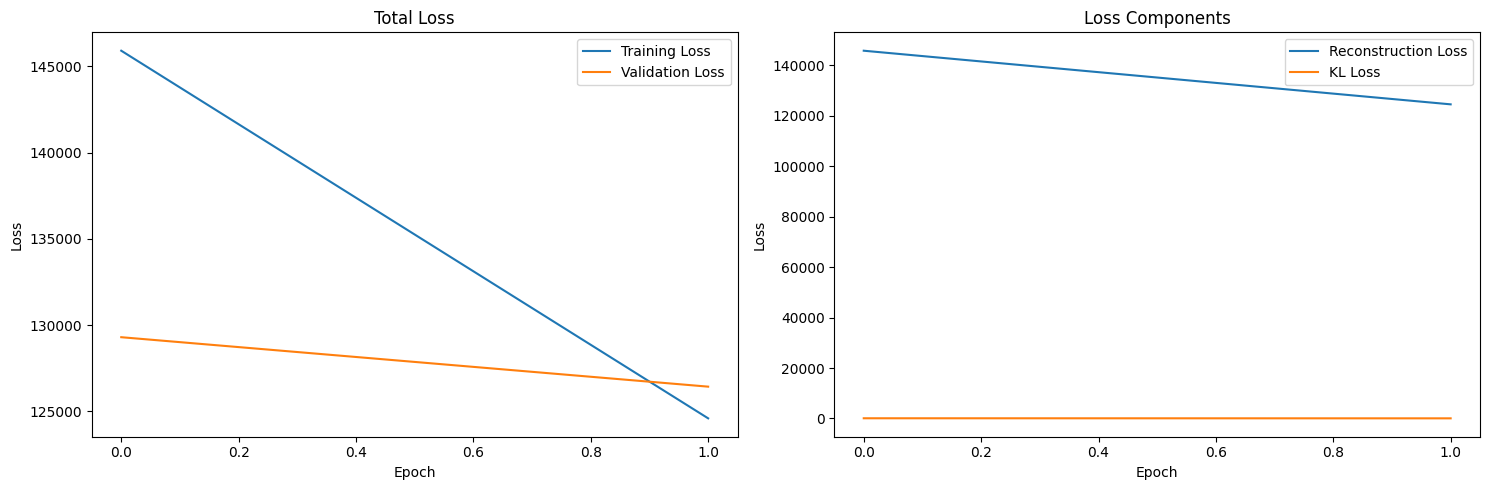

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


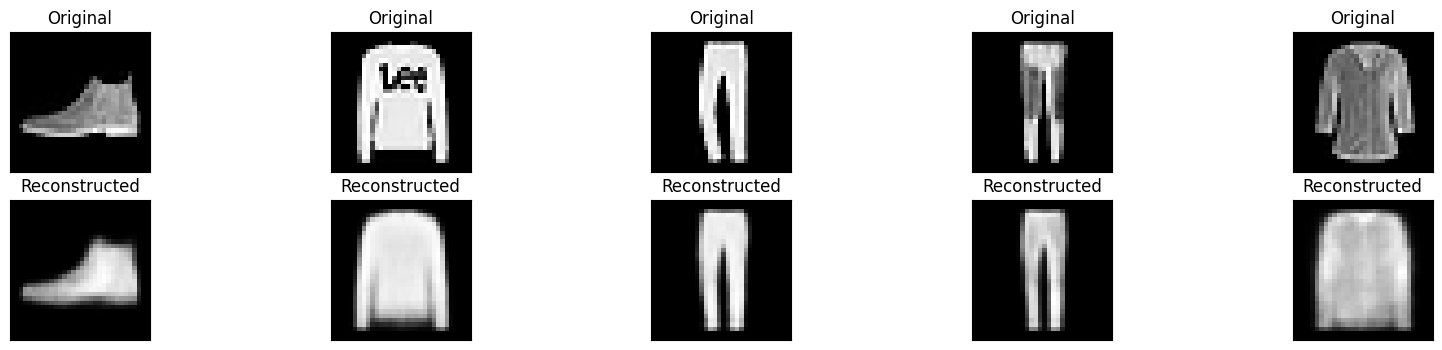

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Shape of z_mean: (10, 3)


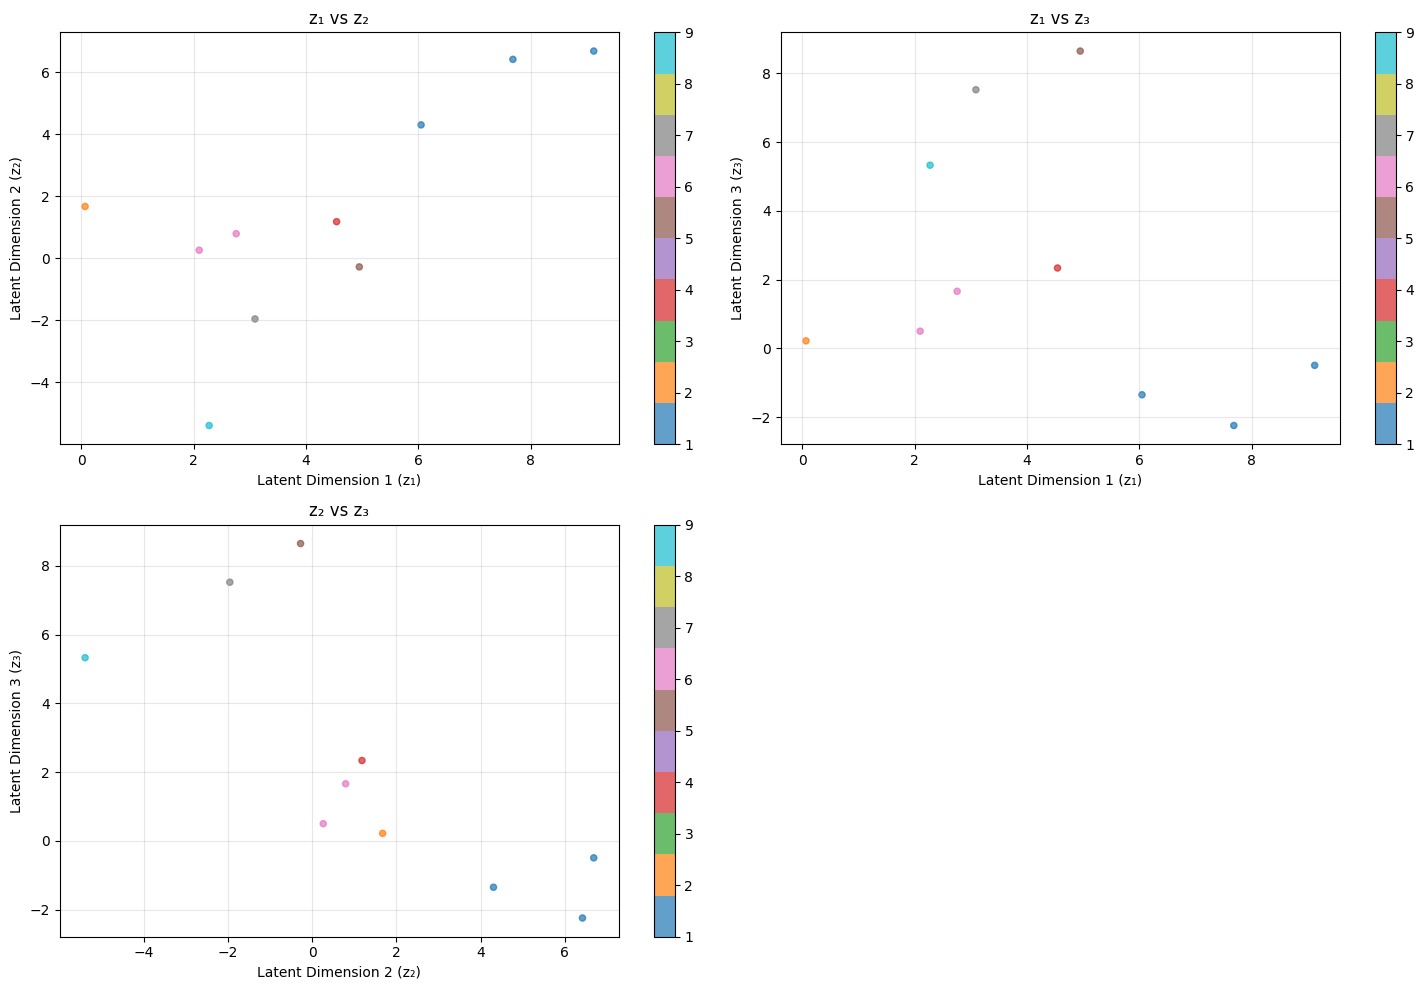

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


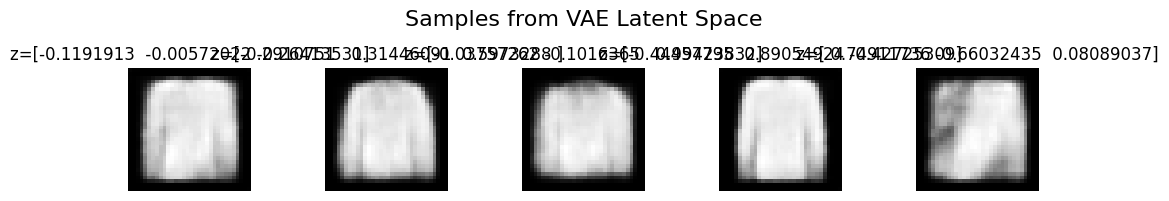

Fashion MNIST class labels:
0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot


In [ ]:
(x_train, y_train), (x_test, y_test) = load_and_preprocess_data()
encoder_inputs = layers.Input(shape=(32, 32, 1))
vae = VAE(encoder_inputs, 3)  # Changed from 2 to 3
vae.compile(optimizer=optimizers.Adam(learning_rate=0.001))
vae.encoder.summary()

history = vae.fit( x_train, epochs=2, batch_size=100, shuffle=True, validation_data=(x_test, None))
plot_training_hist(history)
visulize_reconstruction(vae, x_test)
visulize_latent(vae, x_test)
generate_image(vae, z_range=1)

# Print class names for reference
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
print("Fashion MNIST class labels:")
for i, label in enumerate(fashion_mnist_labels):
    print(f"{i}: {label}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Shape of z_mean: (10000, 3)


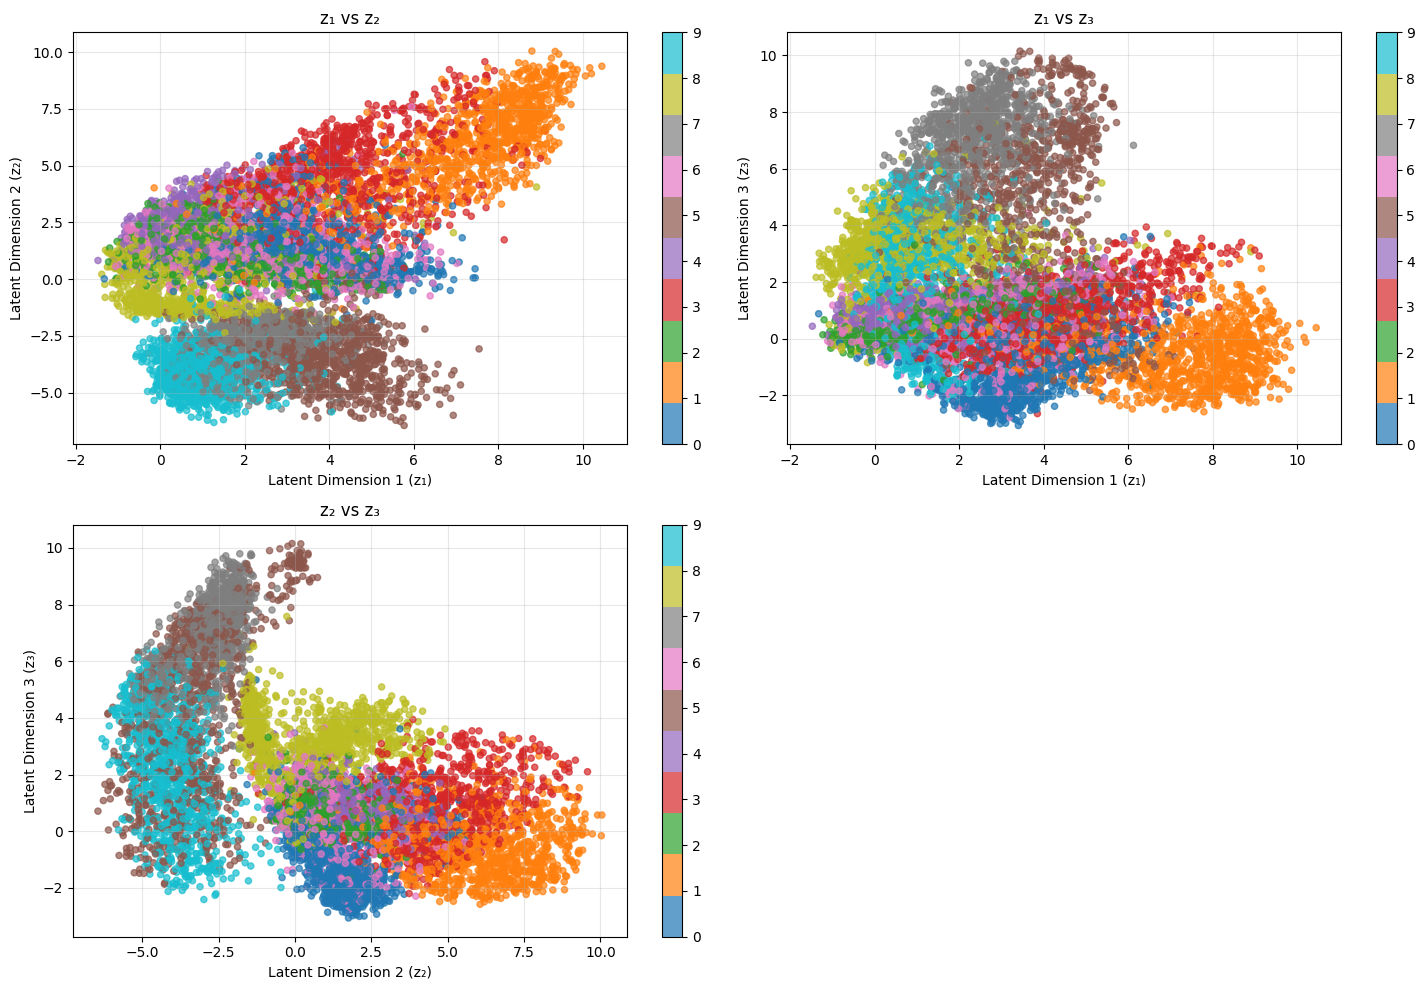

In [ ]:
visulize_latent(vae, x_test,n=10000)

### 🧠 Observations
- The shape of `z_mean` was confirmed to be `(# of test samples, 3)`.
- Visual inspection of pairwise projections shows clusters formed by digit class labels.
- The 3D latent space captures more complex features but limits direct 2D visualization.
- Pairwise plots (z₁ vs z₂, z₁ vs z₃, z₂ vs z₃) help understand latent structure.